In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras import layers

2024-06-02 13:01:02.722049: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-02 13:01:02.722392: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-02 13:01:02.724625: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-02 13:01:02.750381: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-02 13:01:03.403135: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warnin

In [2]:
df = pd.read_csv("TMNIST_DATA.csv")
df

,names,labels,1,2,3,4,5,6,7,8,...,775,776,777,778,779,780,781,782,783,784
0,GrandHotel-Regular,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,EncodeSansCondensed-Medium,8,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Varela-Regular,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ArefRuqaa-Bold,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,KulimPark-Regular,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29895,Raleway[wght],7,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29896,Charm-Regular,5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29897,BigShouldersStencilDisplay-Black,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29898,Gabriela-Regular,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
def inspect(labels, digits, title=None):
    fig, subs = plt.subplots(len(digits)//10, 10, layout='constrained', figsize=(10,(len(digits)//10)))
    if title:
        fig.suptitle(title)

    # Check if we're already dealing with a 2d vs 3d array (3d being ones that are already "images")
    if (len(digits.shape) == 2):
        images = digits.to_numpy().reshape(-1, 28, 28)
    else:
        images = digits
    for img, label, sub in zip(images, labels, [s for sub in subs for s in sub]):
        sub.set_title(label)
        sub.imshow(img, cmap='grey')

In [4]:
digits = df.drop(["names", "labels"], axis=1)

def get_orientation_set(digits):
    length = len(digits)
    rot_0 = digits.to_numpy().reshape(-1, 28, 28)
    rot_270 = np.array([np.rot90(d, k=1) for d in rot_0])
    rot_180 = np.array([np.rot90(d, k=2) for d in rot_0])
    rot_90 = np.array([np.rot90(d, k=3) for d in rot_0])
    all_digits = np.concatenate((rot_0, rot_90, rot_180, rot_270))
    
    all_labels = np.concatenate((
        np.full((length,), 0),
        np.full((length,), 1),
        np.full((length,), 2),
        np.full((length,), 3),
    ))

    assert len(all_digits) == len(all_labels)
    
    p = np.random.permutation(len(all_digits))
    return all_digits[p], all_labels[p]

digits, labels = get_orientation_set(digits)

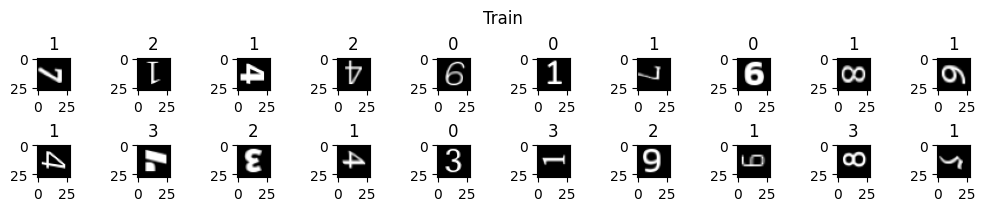

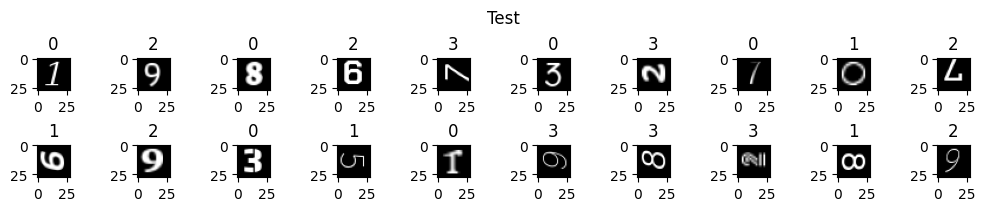

In [5]:
TRAINING_SET = 0.8
r = np.random.default_rng(seed=12345)

training_mask = np.fromiter((r.random() <= TRAINING_SET for _ in range(len(digits))), dtype=bool)

digits_train = digits[training_mask]
digits_test = digits[~training_mask]

labels_train = labels[training_mask]
labels_test = labels[~training_mask]

examples = 20
inspect(labels_train[:20], digits_train[:20], title="Train")
inspect(labels_test[:20], digits_test[:20], title="Test")

In [6]:
x_train = digits_train
x_test = digits_test

y_train = keras.utils.to_categorical(labels_train, 4)
y_test = keras.utils.to_categorical(labels_test, 4)

print(f"Training samples: {len(x_train)}")
print(f"Test samples: {len(x_test)}")

Training samples: 95449
Test samples: 24151


In [13]:
model = keras.Sequential(
    [
        keras.Input(shape=(28, 28, 1)),
        layers.Rescaling(1./255),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(4, activation="softmax"),
    ]
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         6,404 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,220 (98.52 KB)

 Trainable params: 25,220 (98.52 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
batch_size = 128
epochs = 15

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/15
672/672 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.8727 - loss: 0.3432 - val_accuracy: 0.9841 - val_loss: 0.0635
Epoch 2/15
672/672 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.9708 - loss: 0.0927 - val_accuracy: 0.9862 - val_loss: 0.0506
Epoch 3/15
672/672 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9769 - loss: 0.0699 - val_accuracy: 0.9825 - val_loss: 0.0512
Epoch 4/15
672/672 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.9771 - loss: 0.0682 - val_accuracy: 0.9894 - val_loss: 0.0347
Epoch 5/15
672/672 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.9814 - loss: 0.0576 - val_accuracy: 0.9920 - val_loss: 0.0294
Epoch 6/15
672/672 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.9813 - loss: 0.0566 - val_accuracy: 0.9902 - val_loss: 0.0309
Epoch 7/15
672/672 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9824 - loss: 0.0544 - val_accuracy: 0.9899 - val_loss: 0.0325
Epoch 8/15
672/672 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.9830 - loss: 0.0529 - val_accuracy: 0

In [9]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.017399104312062263
Test accuracy: 0.9943273663520813


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


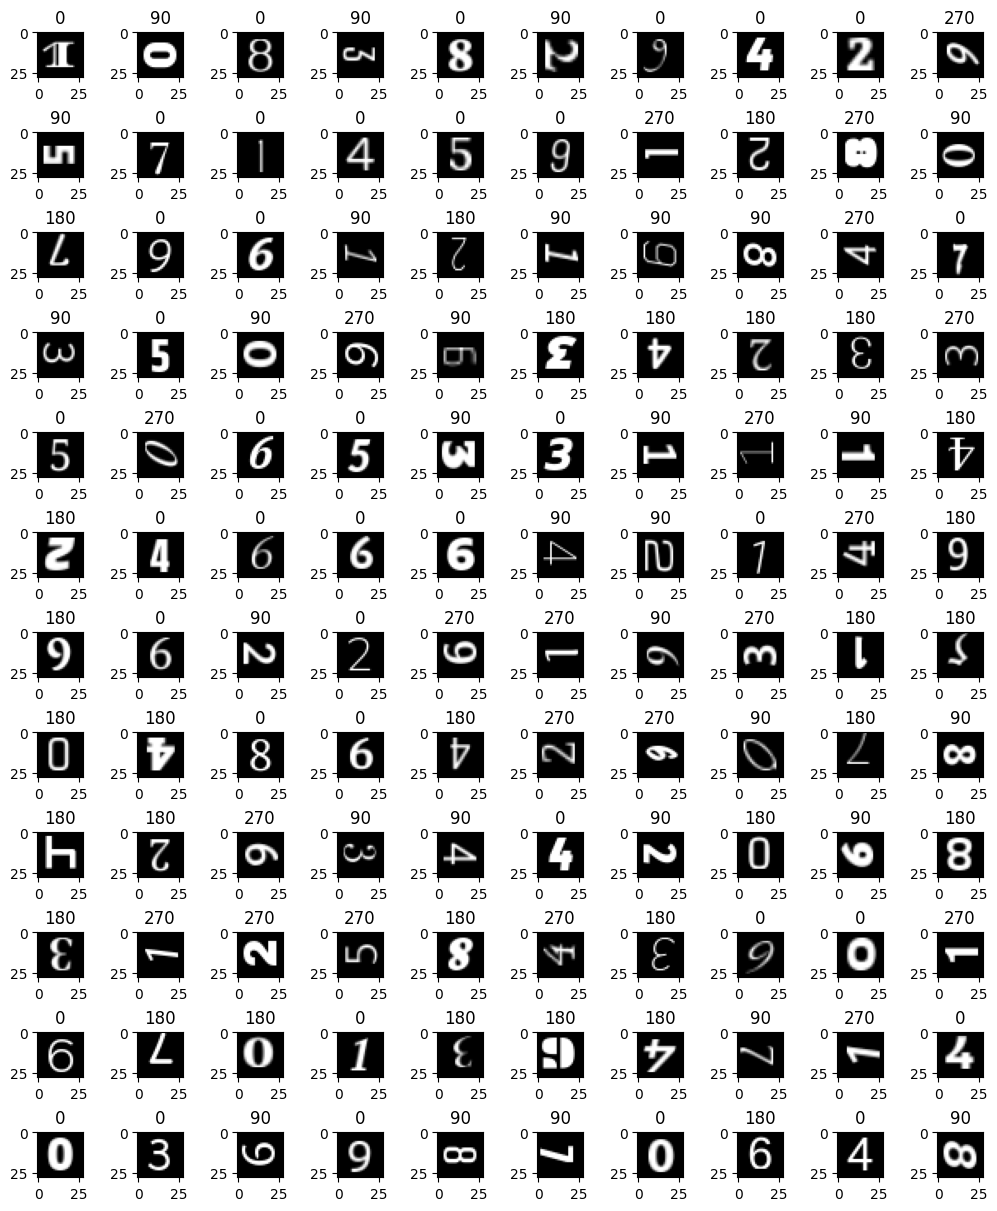

In [12]:
sample = digits[np.random.choice(len(digits), size=120)]
predictions = np.argmax(model.predict(sample), axis=1)

inspect(predictions * 90, sample)